In [84]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from tqdm import tqdm
import os

In [67]:
# mình có S (n*n), X là symetric
# G >= 0, X >= 0
# S = X * X^T
# np.random.seed(42)



def load_adj_matrix(filename: str):
    """
     file:  dimacs10-football/out.dimacs10-football" or "facebook_combined.txt"
     Undirected graph
    """
    with open(filename, "r") as file:
        adj_list = np.array([tuple(map(int, line.split())) for line in file])

    max_node = max(max(edge) for edge in adj_list) + 1
    adj_matrix = np.zeros((max_node, max_node))

    for node1, node2 in adj_list:
        adj_matrix[node1][node2] = 1
        adj_matrix[node2][node1] = 1

    print('>> Max node:', max_node)
    print('>> Adj_matrix: \n', adj_matrix)
    return adj_matrix, adj_list

G, adj_list = load_adj_matrix("facebook_combined.txt")

# G = np.random.randint(0, 1, (2000,2000))
G.shape

>> Max node: 4039
>> Adj_matrix: 
 [[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(4039, 4039)

In [99]:
class SNMF():
    def __init__(
        self,
        adj_matrix: np.ndarray,
        adj_list: np.ndarray = None,
        dimensions: int = 32,
        iterations: int = 600,
        seed: int = 42
    ):
        self.adj_matrix = adj_matrix
        self.adj_list = adj_list
        self.num_node = adj_matrix.shape[0]
        self.num_edge = adj_list.shape[0]
        self.dimensions = dimensions
        self.iterations = iterations
        self.seed = seed


    def modularity(self, adj_matrix, communities: np.ndarray):
        assert adj_matrix.shape[0] == communities.shape[0]
        assert len(communities.shape) == 1
        assert adj_matrix.shape[0] == adj_matrix.shape[1]
        n = adj_matrix.shape[0]
        m = np.sum(adj_matrix) / 2 # number of edges
        k = np.sum(adj_matrix, axis=1) # degree of each node

        Q = 0
        for i in range(n):
            for j in range(n):
                sig = 1 if communities[i] == communities[j] else 0
                Q += (adj_matrix[i][j] - (k[i] * k[j] / (2*m))) * sig / (2*m)

        return Q

    def modularity_dict(self, adj_matrix, communities_dict: dict):
        n = adj_matrix.shape[0]
        m = np.sum(adj_matrix) / 2 # number of edges
        k = np.sum(adj_matrix, axis=1) # degree of each node

        Q = 0
        for community in communities_dict.values():
            for i in community:
                for j in community:
                    Q += (adj_matrix[i][j] - (k[i] * k[j] / (2*m))) / (2*m)

        return Q
    
    def _set_seed(self):
        np.random.seed(self.seed)

    def update(self, G,X):
        numerator = G @ X # Top
        denominator = 2 * X @ X.T @ X  # Bottom
        newX = X * (1/2 + (numerator / denominator))
        return newX

    def get_loss(self, G,X):
        tar = G - X @ X.T
        loss = np.linalg.norm(tar) ** 2
        return loss


    def fit(self, dim: int = 32, clear_stats: bool = False):
        self._set_seed()

        X = np.random.rand(self.num_node, dim) # Start
        losses = []

        os.makedirs(f'results/snmf/runs_{dim}', exist_ok=True)
        print(f"Directory results/snmf/runs_{dim} created successfully!")

        # Iteration
        start_time = time.time()
        for i in tqdm(range(self.iterations)):
            # print(f'>> Iter {i}')
            X = self.update(self.adj_matrix,X)
            loss = self.get_loss(self.adj_matrix,X)

            if i > 0 and losses[-1] - loss < 1e-8:
                print(f'>> Early stopping at iteration {i}')
                break

            losses.append(loss)
        elapsed_time = time.time() - start_time
        
        print('Done iteration!!!')

        # Loss-epochs
        losses_df = pd.DataFrame({"epoch": range(len(losses)), "loss": losses})
        losses_df.to_csv(f'results/snmf/runs_{dim}/losses.csv', index=False)
        print("Done saved losses CSV")
        
        # Save images 
        plt.plot(losses)
        plt.xlabel("Number of epochs")  # Adjust as needed
        plt.ylabel("Loss")
        plt.title(f"Loss of SNMF over time with {dim} communities")
        plt.savefig(f'results/snmf/runs_{dim}/losses.png')
        print('Done saved losses image')

        # Save X
        np.savetxt(f'results/snmf/runs_{dim}/X.txt', X)
        print('Done saved X')

        # Save probabilities
        normalizedX = X / np.sum(X, axis=1, keepdims=True)
        np.savetxt(f'results/snmf/runs_{dim}/prob.txt', normalizedX, fmt='%.2f')
        print('Done saved Probabilities')


        # Community
        communities_list = np.argmax(X, axis=1)
        communities_dict = {}
        for idx, cluster in enumerate(communities_list):
            if cluster in communities_dict:
                communities_dict[cluster].append(idx)
            else:
                communities_dict[cluster] = [idx]

        np.savetxt(f'results/snmf/runs_{dim}/communities.txt', communities_list, fmt='%d')
        print('Done saved Community')

        # num_communities, modularity, epoch_stop, elapsed_time
        stats_path = f"results/snmf/stats.csv"

        if clear_stats:
            os.remove(stats_path)

        # Check if the file exists
        if not os.path.exists(stats_path):
            stats_df = pd.DataFrame(columns=["num_communities", "modularity", "losses", "epoch_stop", "elapsed_time"])
        else:
            stats_df = pd.read_csv(stats_path)

        new_row = {
            "num_communities": dim,
            "modularity": self.modularity_dict(self.adj_matrix, communities_dict),
            "losses": losses[-1],
            "epoch_stop": i,
            "elapsed_time": elapsed_time
        }
        new_df = pd.DataFrame([new_row])
        stats_df = pd.concat([stats_df, new_df], ignore_index=True)

        stats_df.to_csv(stats_path, index=False)
        print('Done save general stats')

    def fit_all(self, low: int, high: int):
        for comm in range(low, high + 1):
            print(f'>>> Community {comm} >>>')
            self.fit(comm)


In [106]:
G, adj_list = load_adj_matrix("facebook_combined.txt")
snmf = SNMF(G,adj_list)
# snmf.fit_all(2,100)

>> Max node: 4039
>> Adj_matrix: 
 [[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


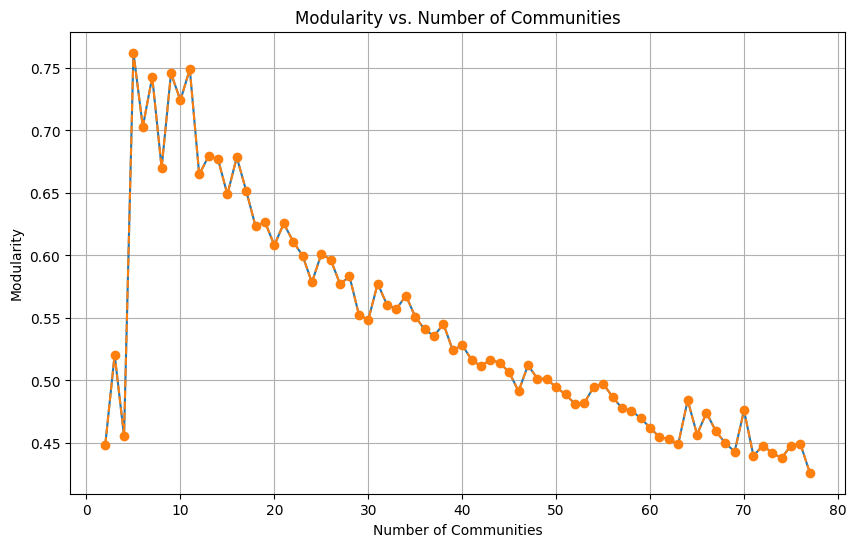

In [110]:
df = pd.read_csv("results/snmf/stats.csv")

# Extract the relevant columns
num_communities = df["num_communities"]
modularity = df["modularity"]

# Create the line chart
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(num_communities, modularity)

# Highlight the value at 16
# index_16 = num_communities.index[num_communities == 16][0]  # Find the index
# plt.plot(index_16, modularity[index_16], marker='o', markersize=15, color='red', label='num_communities = 16')


# Customize the chart
plt.xlabel("Number of Communities")
plt.ylabel("Modularity")
plt.title("Modularity vs. Number of Communities")
plt.grid(True)

# Optional: Add markers for better visualization
plt.plot(num_communities, modularity, marker='o', linestyle='--')

# Show the plot
plt.show()

In [ ]:
# #Comm: 16 
# Modularity: 0.6785339412263144

In [119]:
comm = np.loadtxt('results/snmf/runs_16/communities.txt', dtype='int')
comm.shape

(4039,)

In [145]:
comm = np.loadtxt('results/snmf/runs_16/communities.txt', dtype='int')
df_community = pd.DataFrame({"id": range(len(comm)), "community": comm})

colors = sns.color_palette("husl", n_colors=16).as_hex()
df_colors = pd.DataFrame({"community": range(16), "node_color": colors})


df_combined = pd.merge(df_community,df_colors, on="community", how='inner')
df_combined = df_combined[['id', 'node_color']]

df_combined.to_csv('facebook_metadata.csv', index=False)
df_combined.head(5)

,id,node_color
0,0,#d673f4
1,1,#d673f4
2,2,#d673f4
3,3,#d673f4
4,4,#d673f4


In [ ]:
# Overlapping
# Làm sao tìm được số communities
# Làm sao đo được